In [227]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

np.random.seed(88)

# Phase 1 - HW #1

In [228]:
drilling_costs = pd.read_excel("Analysis_Data.xlsx", sheet_name="Drilling Cost", skiprows=2)
price_projections = pd.read_excel("Analysis_Data.xlsx", sheet_name="Price Projections", skiprows=2)

# subset 1991-2007
drilling_costs = drilling_costs[(drilling_costs['Date'] >= pd.to_datetime("1991-01-01")) & 
                                (drilling_costs['Date'] < pd.to_datetime("2007-06-30"))]

# changing column names
drilling_costs.rename(columns = {'U.S. Nominal Cost per Crude Oil Well Drilled (Thousand Dollars per Well)': 'Crude_Oil_Cost',
                                 'U.S. Nominal Cost per Natural Gas Well Drilled (Thousand Dollars per Well)': 'Natural_Gas_Cost',
                                 'U.S. Nominal Cost per Dry Well Drilled (Thousand Dollars per Well)': "Dry_Well_Cost",
                                 'Arithmetic Return - Crude Oil': 'Crude_Oil_Return',
                                 'Arithmetic Return - Natural Gas': 'Natural_Gas_Return',
                                 'Arithmetic Return - Dry Well': 'Dry_Well_Return'}, inplace=True)

# making numeric
drilling_costs['Crude_Oil_Return'] = pd.to_numeric(drilling_costs['Crude_Oil_Return'])
drilling_costs['Natural_Gas_Return'] = pd.to_numeric(drilling_costs['Natural_Gas_Return'])
drilling_costs['Dry_Well_Return'] = pd.to_numeric(drilling_costs['Dry_Well_Return'])

# Arithmetic changes list
arithmetic_changes = np.concatenate((drilling_costs['Crude_Oil_Return'], 
                                     drilling_costs['Natural_Gas_Return'], 
                                     drilling_costs['Dry_Well_Return']))

# Phase 2 - HW #2

In [229]:
data = []
# Correlation matrix
R = np.array([[1, 0.64], [0.64, 1]])
L = sp.linalg.cholesky(R, lower=False)

# giving you a standardized vector 
def standardize(x):
  x_std = (x - np.mean(x))/np.std(x)
  return(x_std)

# reverseing the standardization
def destandardize(x_std, x):
  x_old = (x_std * np.std(x)) + np.mean(x)
  return(x_old)

production = np.random.lognormal(mean = 6, sigma = 0.28, size = 500000)
decline = np.random.uniform(low = 0.15, high = 0.32, size = 500000)

both_PD = np.array([standardize(decline), standardize(production)])

PD = L @ both_PD

final_PD = np.array([destandardize(PD[0], decline), destandardize(PD[1], production)])


## Dry Well Cost

In [230]:
dry_well = []
for i in range(500000):
    change = np.random.normal(loc = np.mean(arithmetic_changes), scale = np.std(arithmetic_changes))
    drill_2006 = drilling_costs.tail(1)[['Crude_Oil_Cost', 'Natural_Gas_Cost', 'Dry_Well_Cost']].mean(axis = 1)
    
    drill_t = drill_2006 * (1 + change)

    for j in range(5): # 2008-2012
            change = np.random.normal(loc = np.mean(arithmetic_changes), 
                                   scale = np.std(arithmetic_changes))
            drill_t = drill_t * (1 + change)
            
    for j in range(3): # 2013-2015
            change = np.random.triangular(left = -0.22, right = -0.07, mode = -0.0917)
            drill_t = drill_t * (1 + change)

    for j in range(10): # 2016-2025
            change = np.random.triangular(left = 0.02, right = 0.06, mode = 0.05)
            drill_t = drill_t * (1 + change)
            
    drill_2025 = drill_t
    
    prof_overhead = np.random.triangular(left = 172000, mode = 215000, 
                                         right = 279500, size = 1)
    acres = np.random.normal(loc = 600, scale = 50, size = 1)
    sections = np.random.normal(loc = 3, scale = 0.35, size = 1)
    
    lease_cost = 960 * acres
    seismic_cost = 43000 * sections
    drilling_cost = drill_2025 * 1000
    
    dry = lease_cost + seismic_cost + drilling_cost + prof_overhead
    
    dry_well.append(dry)
    
dry_well_costs = np.array(dry_well).flatten()


## Wet Well NPV

In [231]:
price_fut = [0]*15
for k in range(15):
    price_fut[k] = np.random.triangular(left = price_projections['Low Oil Price'].iloc[k], 
                                        mode = price_projections['AEO2023 Reference'].iloc[k], 
                                        right = price_projections['High Oil Price'].iloc[k])

operating_cost = [0]*15
for k in range(15):
    operating_cost[k] = np.random.normal(loc = 2.25, scale = 0.3)

WACC = [0]*15
for k in range(1, 16):
    WACC[k-1] = (1 + 0.1)**k

In [232]:
wet_well = []

for i in range(500000):
    change = np.random.normal(loc = np.mean(arithmetic_changes), scale = np.std(arithmetic_changes))
    drill_2006 = drilling_costs.tail(1)[['Crude_Oil_Cost', 'Natural_Gas_Cost',
                                         'Dry_Well_Cost']].mean(axis = 1)
    
    drill_t = drill_2006 * (1 + change)

    for j in range(5):
            change = np.random.normal(loc = np.mean(arithmetic_changes), 
                                   scale = np.std(arithmetic_changes))
            drill_t = drill_t * (1 + change)
            
    for j in range(3):
            change = np.random.triangular(left = -0.22, right = -0.07, mode = -0.0917)
            drill_t = drill_t * (1 + change)

    for j in range(10):
            change = np.random.triangular(left = 0.02, right = 0.06, mode = 0.05)
            drill_t = drill_t * (1 + change)
            
    drill_2025 = drill_t
    
    prof_overhead = np.random.triangular(left = 172000, mode = 215000, 
                                         right = 279500, size = 1)
    acres = np.random.normal(loc = 600, scale = 50, size = 1)
    sections = np.random.normal(loc = 3, scale = 0.35, size = 1)
    
    comp_cost = np.random.normal(loc = 390000, scale = 50000, size = 1)
    
    lease_cost = 960 * acres
    seismic_cost = 43000 * sections
    drilling_cost = drill_2025 * 1000
    
    wet0 = lease_cost + seismic_cost + drilling_cost + prof_overhead + comp_cost
    
    begin_prod = [0] * 15
    end_prod = [0] * 15
    for k in range(15):
        begin_prod[k] = final_PD[1, i] * (1 - final_PD[0, i])**k
        end_prod[k] = final_PD[1, i] * (1 - final_PD[0, i])**(k + 1)
        
    annual_vol = 365 * ((np.array(begin_prod) + np.array(end_prod)) / 2)
    revenue = annual_vol * np.array(price_fut)
    total_cost = np.array(operating_cost) * annual_vol + prof_overhead
    
    NRI = np.random.normal(loc = 0.75, scale = 0.02)
    sev_tax = 0.046
    revenue_nri = revenue*NRI
    
    net_revenue_taxed = (revenue_nri - total_cost)*(1 - sev_tax)
    
    wet = (net_revenue_taxed / WACC).sum() - wet0
    
    wet_well.append(wet)


wet_well_npv = np.array(wet_well).flatten()


# Phase 3

## Simulate Probablity of Wet Well & Hydrocarbons

c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


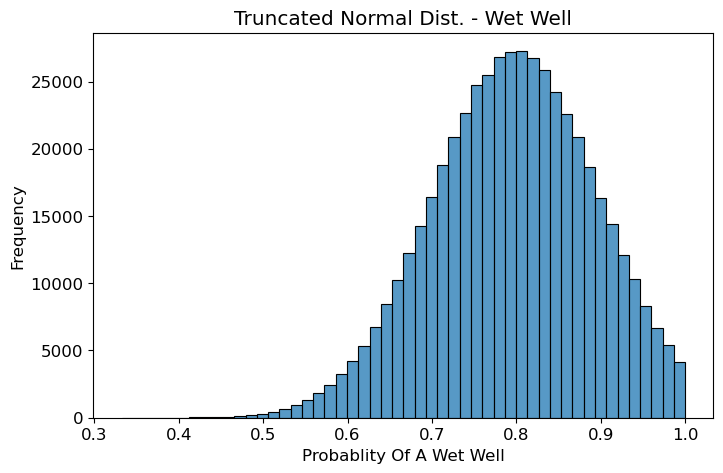

c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


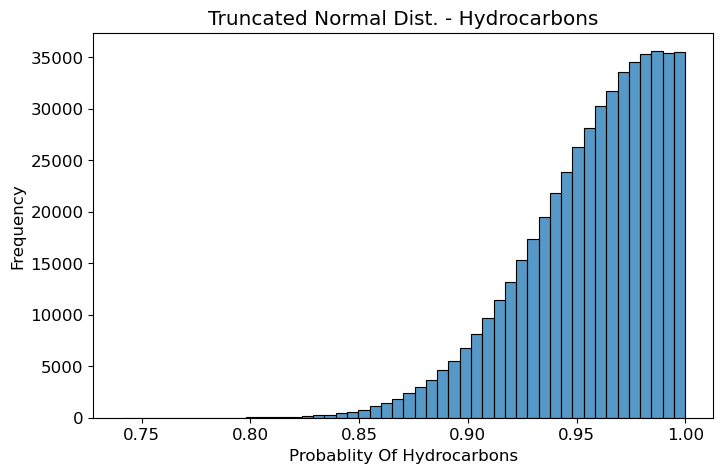

In [233]:
# P(wet) 
a, b = 0, 1  # Truncation limits (probabilities between 0 and 1)
mu, sigma = 0.80, 0.1  # Mean and standard deviation of the normal distribution
trunc_norm = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
p_wet = trunc_norm.rvs(size=500000)  # Sample a probability value 500000 times

# Plot P(wet)  out
plt.figure(figsize=(8, 5)) 
ax = sns.histplot(data=p_wet, bins=50)
ax.set_title("Truncated Normal Dist. - Wet Well")
ax.set_xlabel("Probablity Of A Wet Well")
ax.set_ylabel("Frequency")
plt.show()


# P(hydrocarbons) 
a, b = 0, 1  # Truncation limits (probabilities between 0 and 1)
mu, sigma = 0.99, 0.05  # Mean and standard deviation of the normal distribution
trunc_norm = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
p_hydro = trunc_norm.rvs(size=500000)  # Sample a probability value 500000 times

# Plot P(hydrocarbons) out
plt.figure(figsize=(8, 5)) 
ax = sns.histplot(data=p_hydro, bins=50)
ax.set_title("Truncated Normal Dist. - Hydrocarbons")
ax.set_xlabel("Probablity Of Hydrocarbons")
ax.set_ylabel("Frequency")
plt.show()

## Determine The Number of Drillable Wells

c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


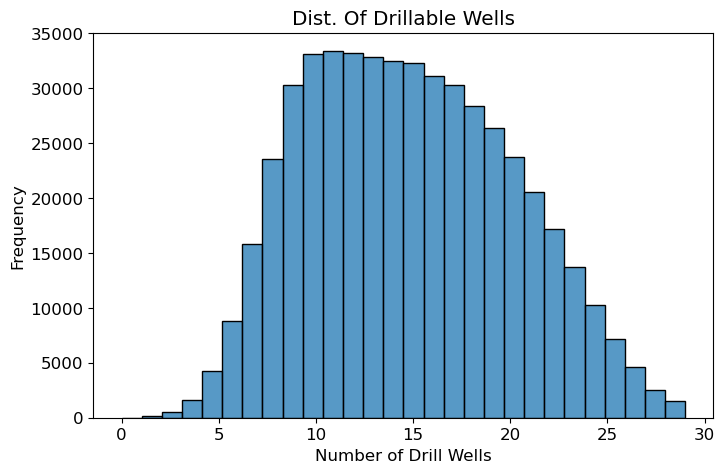

In [243]:
# Simulate number of total wells
num_wells = np.random.uniform(low = 10, high = 30, size=500000).astype(int) # cast as int bc cant have half a well (always rounding down)

# Simulate how many of the total wells are wet
producing_wells = np.random.binomial(n=num_wells, p=p_wet)

# Simulate how many of the wet wells have hydrocarbons present
hydrocarbon_wells = np.random.binomial(n=producing_wells, p=p_hydro)

# each sims total wells and drillable wells
wells = np.column_stack((hydrocarbon_wells, num_wells-hydrocarbon_wells))


# Plot it out
plt.figure(figsize=(8, 5)) 
ax = sns.histplot(hydrocarbon_wells, bins=28)
ax.set_title("Dist. Of Drillable Wells")
ax.set_xlabel("Number of Drill Wells")
ax.set_ylabel("Frequency")
plt.show()

In [245]:
# VaR at 5% level
drill_Var = np.quantile(hydrocarbon_wells, 0.05)
print(f'The 5% VaR for drillable wells is {drill_Var}')

# Conditional VaR at 5% level
drill_CVaR = np.mean(hydrocarbon_wells[hydrocarbon_wells < drill_Var])
print(f'The 5% CVaR for drillable wells is {drill_CVaR}')

The 5% VaR for drillable wells is 7.0
The 5% CVaR for drillable wells is 5.38290060319958


## Final NPV

In [247]:
final_npv = []
for i in range(500000):
    n_wet = wells[i, 0] 
    n_dry = wells[i, 1]
    dry_costs = np.random.choice(dry_well_costs, size=n_dry).sum()
    wet_npv = np.random.choice(wet_well_npv, size=n_wet).sum()
    npv = wet_npv - dry_costs 
    final_npv.append(npv)

final_npv = np.array(final_npv)

C:\Users\Sterling Hayden\AppData\Local\Temp\ipykernel_636\2903145121.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x / 1e6}M" for x in ax.get_xticks()])


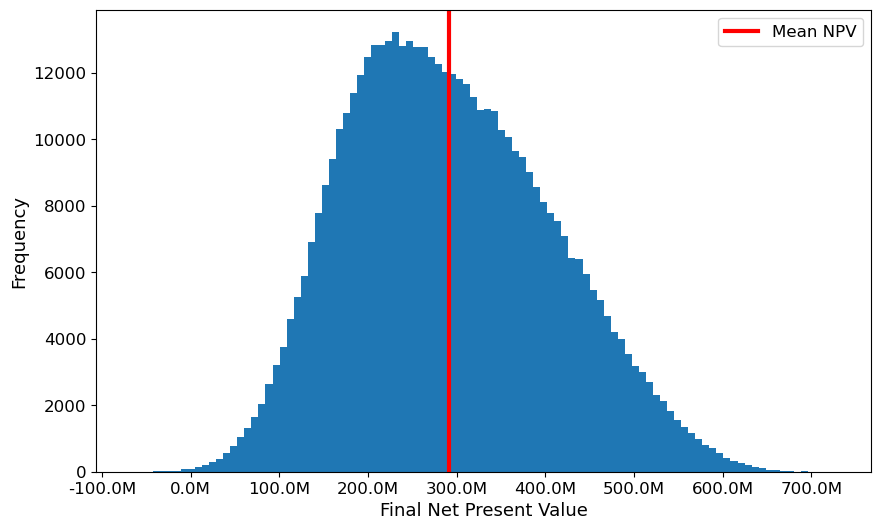

In [248]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(final_npv, bins=100)
ax.axvline(np.mean(final_npv), color="red", linewidth=3, label="Mean NPV") 
ax.set_xticklabels([f"{x / 1e6}M" for x in ax.get_xticks()])
plt.xlabel("Final Net Present Value", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
ax.legend(fontsize=12)
plt.show()

In [249]:
# Mean NPV
print(f'The mean NPV for a given wells is {np.mean(final_npv)}')

# VaR at 5% level
NPV_VaR = np.quantile(final_npv, 0.05)
print(f'The 5% VaR for given wells is {NPV_VaR}')

# Conditional VaR at 5% level
NPV_CVaR = final_npv[final_npv < NPV_VaR].mean()
print(f'The 5% CVaR for given wells is {NPV_CVaR}')

The mean NPV for a given wells is 291871595.3950533
The 5% VaR for given wells is 119708844.3556122
The 5% CVaR for given wells is 88697418.1306881
